This one is to provide at least something of an answer for a question I'm curious about, plus it's an excuse to play with a new data set. 

It has always somewhat bothered me that we don't don't insist that people try different random starting points when using standard N-fold cross validation to test model performance. If there's a random process involved in splitting the data into the N-folds, then it seems logical to test how much the results depend on that split. Given that sklearn provides a utility function for doing this, [RepeatedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold), the idea obviously isn't totally alien for all people doing model building. However, I almost never see it in cheminformatics/QSAR.

Part of my wondering about this is certainly due to the fact that I don't really understand the reasoning behind doing K-fold cross validation in the first place when working with data sets containing more than one hundred or so points. The usual argument I hear is something like: "but then you know that each data point has been used to test the model". This isn't strictly true, each data point has been used to test *one of* the models, and I'm not sure that it's important when we have more than handful of data.

Anyway, here I wanted to check how much of a difference the random seed used for K-fold cross validation can make. I look at the distributions of two different quality metrics (AUC and kappa) for random forest and XGBoost models built for three different endpoints from a recent [JCIM paper from Gilead](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00160) which includes a collection of consistently measured ADME data on a bunch of compounds. I also look at how often the different random K-fold splits lead to different conclusions when asking the question: "is one model better than the other?".

The full results are below, but here's a quick summary of one way of looking at the results.

These boxplots look at Cohen's kappa (left plot) and AUROC (right plot) for classifiers built on the MDCK dataset. The left pair of bars in each plot show the distribution of values for 100 random splits, the right pair show distributions for 50 different 5-fold cross validations. The left bar in each pair has the results for XGB, the right bar for RF.

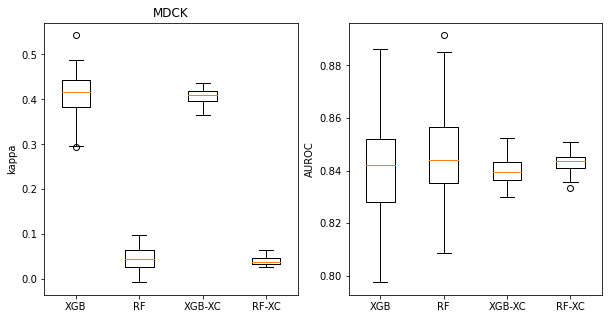

We can see that the distributions are significantly narrower for the 5-fold cross validation, but that there is still a spread of values. This spread becomes more significant if we are trying to use the cross validation to answer the question "Which method gives higher AUROC values for this data set, RF or XGB?". The distribution makes it clear that RF is a bit better, but since the difference is small 16% of the cross validation splits would have lead to the other conclusion.

It's probably worth coming back to this at some point and doing a broader set of data sets and methods in order to be more certain about the conclusions, but I think this already indicates that it wouldn't be a *terrible* idea to try different K-fold splits when comparing models where the performance differences are not large. 


In [52]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import rdkit
print(rdkit.__version__)

2023.03.2


In [3]:
# data set from here: https://github.com/molecularinformatics/Computational-ADME/blob/main/ADME_public_set_3521.csv
# from this publication: https://pubs.acs.org/doi/10.1021/acs.jcim.3c00160
df = pd.read_csv('../data/ADME_public_set_3521.csv')
df.head()

,Internal ID,Vendor ID,SMILES,CollectionName,LOG HLM_CLint (mL/min/kg),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG RLM_CLint (mL/min/kg)
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,0.675687,1.493167,0.089905,0.991226,0.518514,1.392169
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,0.675687,1.040780,0.550228,0.099681,0.268344,1.027920
2,Mol3,304005766,CN(c1ncc(F)cn1)[C@H]1CCCNC1,emolecules,0.675687,-0.358806,NaN,2.000000,2.000000,1.027920
3,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,0.675687,1.026662,1.657056,-1.158015,-1.403403,1.027920
4,Mol5,324059015,CC(C)(O)CCn1cc2cc(NC(=O)c3cccc(C(F)(F)F)n3)c(C...,emolecules,0.996380,1.010597,NaN,1.015611,1.092264,1.629093


# HLM data set

In [18]:
hlm_df = df[df['LOG HLM_CLint (mL/min/kg)'].notnull()].copy()
hlm_df.shape

(3087, 10)

Take a look at the distribution of values to figure out where to place the "active/inactive" bin for classification.

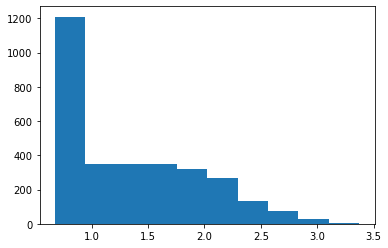

In [19]:
plt.hist(hlm_df['LOG HLM_CLint (mL/min/kg)']);

In [20]:
hlm_df[hlm_df['LOG HLM_CLint (mL/min/kg)']>1.5].shape

(1162, 10)

In [21]:
hlm_df['active'] = [int(x) for x in hlm_df['LOG HLM_CLint (mL/min/kg)']>1.5]

We'll use standard fingerprints for this:

In [22]:
ms = [Chem.MolFromSmiles(x) for x in hlm_df['SMILES']]
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=2048)
fps = [fpg.GetCountFingerprintAsNumPy(x) for x in ms]

In [28]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    cohen_kappa_score
)
metrics = {
    'balanced_accuracy_score':balanced_accuracy_score,
    'cohen_kappa_score':cohen_kappa_score,
}

Start by doing 100 random splits to get a sense for the amount of variability there.

In [47]:
from sklearn.model_selection import train_test_split

acts = hlm_df['active'].to_list()

rf_accum = []
xgb_accum = []
for i in range(100):
    if not (i+1)%10:
        print(f'iteration {i+1}')
    X_train, X_test, y_train, y_test = train_test_split(fps,acts, test_size=0.2, random_state=0xf00d+i, stratify=acts)
    cls = RandomForestClassifier(n_estimators=200,max_depth=20,min_samples_leaf=2,min_samples_split=4, n_jobs=6, random_state=0xfeed)
    cls.fit(X_train,y_train)
    test_probs = [x[1] for x in cls.predict_proba(X_test)]
    test_preds = cls.predict(X_test)
    res = {}
    for metric in metrics:
        res[metric] = metrics[metric](y_test,test_preds)

    res['roc_auc_score'] = roc_auc_score(y_test,test_probs)
    res['average_precision_score'] = average_precision_score(y_test,test_probs)    
    rf_accum.append(res)

    cls = XGBClassifier(n_estimators=200,max_depth=3, n_jobs=6)
    cls.fit(X_train,y_train)
    test_probs = [x[1] for x in cls.predict_proba(X_test)]
    test_preds = cls.predict(X_test)
    res = {}
    for metric in metrics:
        res[metric] = metrics[metric](y_test,test_preds)

    res['roc_auc_score'] = roc_auc_score(y_test,test_probs)
    res['average_precision_score'] = average_precision_score(y_test,test_probs)    
    xgb_accum.append(res)
    
    

    
    

iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100


In [51]:
import pickle
with open('./results/xc_variability_random_splits.pkl','wb+') as outf:
    pickle.dump((rf_accum,xgb_accum),outf)

Look at the distribution of values for the normal random splits:

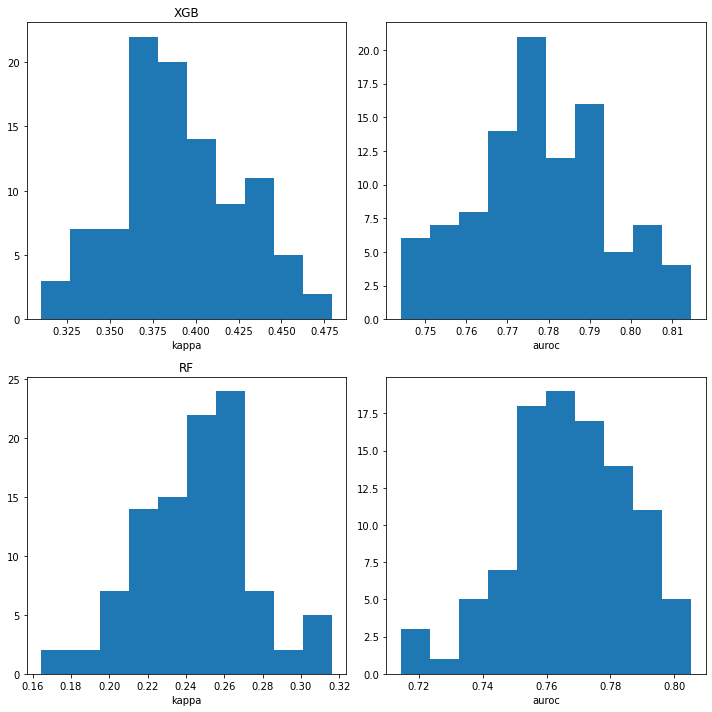

In [49]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist([x['cohen_kappa_score'] for x in xgb_accum]);
plt.xlabel('kappa')
plt.title('XGB')
plt.subplot(2,2,2)
plt.hist([x['roc_auc_score'] for x in xgb_accum]);
plt.xlabel('auroc')

plt.subplot(2,2,3)
plt.hist([x['cohen_kappa_score'] for x in rf_accum]);
plt.xlabel('kappa')
plt.title('RF')
plt.subplot(2,2,4)
plt.hist([x['roc_auc_score'] for x in rf_accum]);
plt.xlabel('auroc')

plt.tight_layout()


Now do 50 different 5-fold cross validation runs

In [66]:
from sklearn.model_selection import StratifiedKFold

acts = hlm_df['active'].to_numpy()


rf_xc_accum = []
xgb_xc_accum = []
for i in range(50):
    print(f'iteration {i+1}')
    skf = StratifiedKFold(n_splits=5,random_state=0xf00d+i,shuffle=True)
    lres = []
    for train_idx,test_idx in skf.split(fps,acts):
        X_train = np.take(fps,train_idx,axis=0)
        X_test = np.take(fps,test_idx,axis=0)
        y_train = np.take(acts,train_idx)
        y_test = np.take(acts,test_idx)
        
        cls = RandomForestClassifier(n_estimators=200,max_depth=20,min_samples_leaf=2,min_samples_split=4, n_jobs=6, random_state=0xfeed)
        cls.fit(X_train,y_train)
        test_probs = [x[1] for x in cls.predict_proba(X_test)]
        test_preds = cls.predict(X_test)
        res = {}
        for metric in metrics:
            res[metric] = metrics[metric](y_test,test_preds)

        res['roc_auc_score'] = roc_auc_score(y_test,test_probs)
        res['average_precision_score'] = average_precision_score(y_test,test_probs)    

        cls = XGBClassifier(n_estimators=200,max_depth=3, n_jobs=6)
        cls.fit(X_train,y_train)
        test_probs = [x[1] for x in cls.predict_proba(X_test)]
        test_preds = cls.predict(X_test)
        xgres = {}
        for metric in metrics:
            xgres[metric] = metrics[metric](y_test,test_preds)
        xgres['roc_auc_score'] = roc_auc_score(y_test,test_probs)
        xgres['average_precision_score'] = average_precision_score(y_test,test_probs)    
        lres.append((res,xgres))
    tres = {}
    for k in xgres:
        tres[k] = [x[0][k] for x in lres]
    rf_xc_accum.append(tres)
    tres = {}
    for k in xgres:
        tres[k] = [x[1][k] for x in lres]
    xgb_xc_accum.append(tres)
    
    

    
    

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50


In [67]:
import pickle
with open('./results/xc_variability_xc.pkl','wb+') as outf:
    pickle.dump((rf_xc_accum,xgb_xc_accum),outf)

And look at the variability

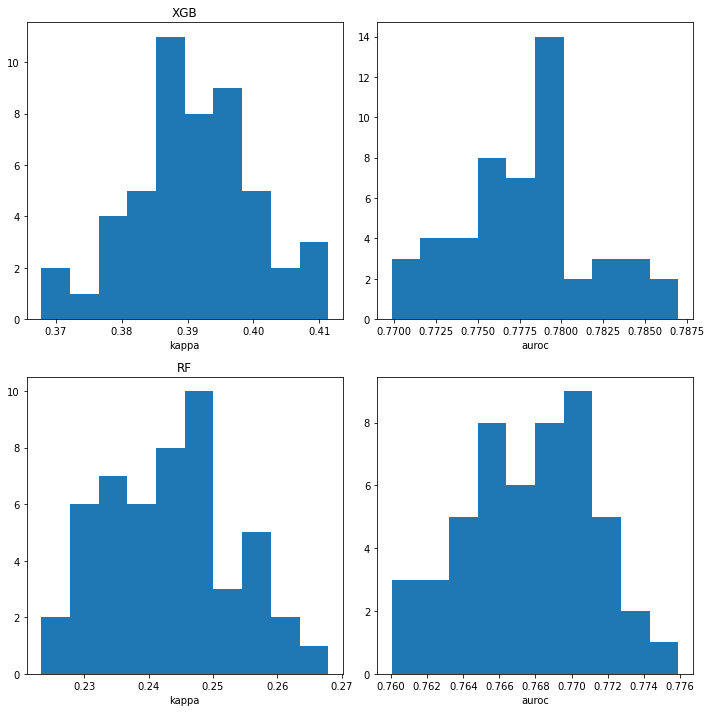

In [68]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist([np.mean(x['cohen_kappa_score']) for x in xgb_xc_accum]);
plt.xlabel('kappa')
plt.title('XGB')
plt.subplot(2,2,2)
plt.hist([np.mean(x['roc_auc_score']) for x in xgb_xc_accum]);
plt.xlabel('auroc')

plt.subplot(2,2,3)
plt.hist([np.mean(x['cohen_kappa_score']) for x in rf_xc_accum]);
plt.xlabel('kappa')
plt.title('RF')
plt.subplot(2,2,4)
plt.hist([np.mean(x['roc_auc_score']) for x in rf_xc_accum]);
plt.xlabel('auroc')

plt.tight_layout()


# MDCK dataset 

In [78]:
mdck_df = df[df['LOG MDR1-MDCK ER (B-A/A-B)'].notnull()].copy()
mdck_df.shape

(2642, 10)

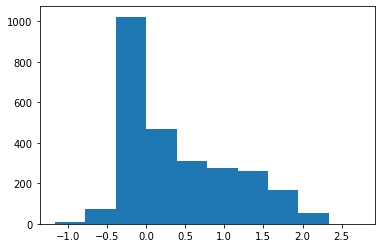

In [76]:
plt.hist(mdck_df['LOG MDR1-MDCK ER (B-A/A-B)']);

In [79]:
mdck_df[mdck_df['LOG MDR1-MDCK ER (B-A/A-B)']>1].shape

(587, 10)

In [80]:
mdck_df['active'] = [int(x) for x in mdck_df['LOG MDR1-MDCK ER (B-A/A-B)']>1]
ms = [Chem.MolFromSmiles(x) for x in mdck_df['SMILES']]
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=2048)
fps = [fpg.GetCountFingerprintAsNumPy(x) for x in ms]

In [81]:
from sklearn.model_selection import train_test_split

acts = mdck_df['active'].to_list()

mdck_rf_accum = []
mdck_xgb_accum = []
for i in range(100):
    if not (i+1)%10:
        print(f'iteration {i+1}')
    X_train, X_test, y_train, y_test = train_test_split(fps,acts, test_size=0.2, random_state=0xf00d+i, stratify=acts)
    cls = RandomForestClassifier(n_estimators=200,max_depth=20,min_samples_leaf=2,min_samples_split=4, n_jobs=6, random_state=0xfeed)
    cls.fit(X_train,y_train)
    test_probs = [x[1] for x in cls.predict_proba(X_test)]
    test_preds = cls.predict(X_test)
    res = {}
    for metric in metrics:
        res[metric] = metrics[metric](y_test,test_preds)

    res['roc_auc_score'] = roc_auc_score(y_test,test_probs)
    res['average_precision_score'] = average_precision_score(y_test,test_probs)    
    mdck_rf_accum.append(res)

    cls = XGBClassifier(n_estimators=200,max_depth=3, n_jobs=6)
    cls.fit(X_train,y_train)
    test_probs = [x[1] for x in cls.predict_proba(X_test)]
    test_preds = cls.predict(X_test)
    res = {}
    for metric in metrics:
        res[metric] = metrics[metric](y_test,test_preds)

    res['roc_auc_score'] = roc_auc_score(y_test,test_probs)
    res['average_precision_score'] = average_precision_score(y_test,test_probs)    
    mdck_xgb_accum.append(res)
    
import pickle
with open('./results/mdck_xc_variability_random_splits.pkl','wb+') as outf:
    pickle.dump((mdck_rf_accum,mdck_xgb_accum),outf)    

    
    

iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100


In [82]:
from sklearn.model_selection import StratifiedKFold

acts = mdck_df['active'].to_numpy()


mdck_rf_xc_accum = []
mdck_xgb_xc_accum = []
for i in range(50):
    print(f'iteration {i+1}')
    skf = StratifiedKFold(n_splits=5,random_state=0xf00d+i,shuffle=True)
    lres = []
    for train_idx,test_idx in skf.split(fps,acts):
        X_train = np.take(fps,train_idx,axis=0)
        X_test = np.take(fps,test_idx,axis=0)
        y_train = np.take(acts,train_idx)
        y_test = np.take(acts,test_idx)
        
        cls = RandomForestClassifier(n_estimators=200,max_depth=20,min_samples_leaf=2,min_samples_split=4, n_jobs=6, random_state=0xfeed)
        cls.fit(X_train,y_train)
        test_probs = [x[1] for x in cls.predict_proba(X_test)]
        test_preds = cls.predict(X_test)
        res = {}
        for metric in metrics:
            res[metric] = metrics[metric](y_test,test_preds)

        res['roc_auc_score'] = roc_auc_score(y_test,test_probs)
        res['average_precision_score'] = average_precision_score(y_test,test_probs)    

        cls = XGBClassifier(n_estimators=200,max_depth=3, n_jobs=6)
        cls.fit(X_train,y_train)
        test_probs = [x[1] for x in cls.predict_proba(X_test)]
        test_preds = cls.predict(X_test)
        xgres = {}
        for metric in metrics:
            xgres[metric] = metrics[metric](y_test,test_preds)
        xgres['roc_auc_score'] = roc_auc_score(y_test,test_probs)
        xgres['average_precision_score'] = average_precision_score(y_test,test_probs)    
        lres.append((res,xgres))
    tres = {}
    for k in xgres:
        tres[k] = [x[0][k] for x in lres]
    mdck_rf_xc_accum.append(tres)
    tres = {}
    for k in xgres:
        tres[k] = [x[1][k] for x in lres]
    mdck_xgb_xc_accum.append(tres)
    
    
import pickle
with open('./results/mdck_xc_variability_xc.pkl','wb+') as outf:
    pickle.dump((mdck_rf_xc_accum,mdck_xgb_xc_accum),outf)
    
    

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50


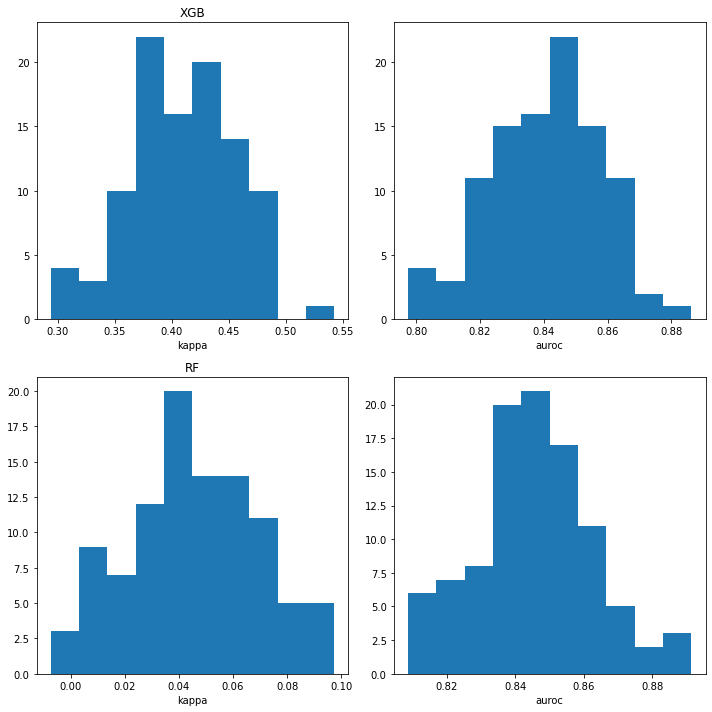

In [98]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist([x['cohen_kappa_score'] for x in mdck_xgb_accum]);
plt.xlabel('kappa')
plt.title('XGB')
plt.subplot(2,2,2)
plt.hist([x['roc_auc_score'] for x in mdck_xgb_accum]);
plt.xlabel('auroc')

plt.subplot(2,2,3)
plt.hist([x['cohen_kappa_score'] for x in mdck_rf_accum]);
plt.xlabel('kappa')
plt.title('RF')
plt.subplot(2,2,4)
plt.hist([x['roc_auc_score'] for x in mdck_rf_accum]);
plt.xlabel('auroc')

plt.tight_layout()


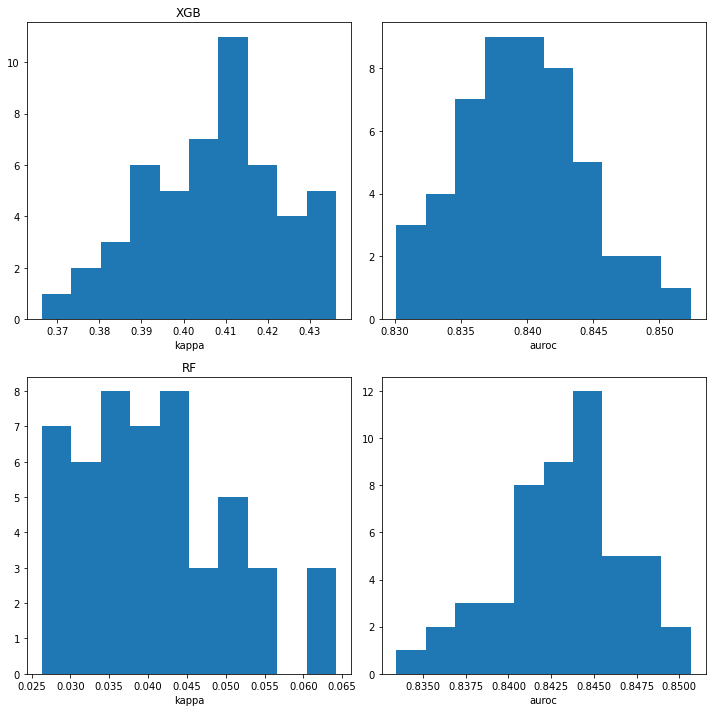

In [83]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist([np.mean(x['cohen_kappa_score']) for x in mdck_xgb_xc_accum]);
plt.xlabel('kappa')
plt.title('XGB')
plt.subplot(2,2,2)
plt.hist([np.mean(x['roc_auc_score']) for x in mdck_xgb_xc_accum]);
plt.xlabel('auroc')

plt.subplot(2,2,3)
plt.hist([np.mean(x['cohen_kappa_score']) for x in mdck_rf_xc_accum]);
plt.xlabel('kappa')
plt.title('RF')
plt.subplot(2,2,4)
plt.hist([np.mean(x['roc_auc_score']) for x in mdck_rf_xc_accum]);
plt.xlabel('auroc')

plt.tight_layout()


# PPB data set (smaller)

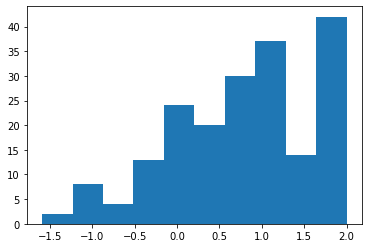

In [94]:
ppb_df = df[df['LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)'].notnull()].copy()
plt.hist(ppb_df['LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)']);

In [95]:
ppb_df['active'] = [int(x) for x in ppb_df['LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)']>1]
ms = [Chem.MolFromSmiles(x) for x in ppb_df['SMILES']]
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=2048)
fps = [fpg.GetCountFingerprintAsNumPy(x) for x in ms]

In [96]:
from sklearn.model_selection import train_test_split

acts = ppb_df['active'].to_list()

ppb_rf_accum = []
ppb_xgb_accum = []
for i in range(100):
    if not (i+1)%10:
        print(f'iteration {i+1}')
    X_train, X_test, y_train, y_test = train_test_split(fps,acts, test_size=0.2, random_state=0xf00d+i, stratify=acts)
    cls = RandomForestClassifier(n_estimators=200,max_depth=20,min_samples_leaf=2,min_samples_split=4, n_jobs=6, random_state=0xfeed)
    cls.fit(X_train,y_train)
    test_probs = [x[1] for x in cls.predict_proba(X_test)]
    test_preds = cls.predict(X_test)
    res = {}
    for metric in metrics:
        res[metric] = metrics[metric](y_test,test_preds)

    res['roc_auc_score'] = roc_auc_score(y_test,test_probs)
    res['average_precision_score'] = average_precision_score(y_test,test_probs)    
    ppb_rf_accum.append(res)

    cls = XGBClassifier(n_estimators=200,max_depth=3, n_jobs=6)
    cls.fit(X_train,y_train)
    test_probs = [x[1] for x in cls.predict_proba(X_test)]
    test_preds = cls.predict(X_test)
    res = {}
    for metric in metrics:
        res[metric] = metrics[metric](y_test,test_preds)

    res['roc_auc_score'] = roc_auc_score(y_test,test_probs)
    res['average_precision_score'] = average_precision_score(y_test,test_probs)    
    ppb_xgb_accum.append(res)
    
import pickle
with open('./results/ppb_xc_variability_random_splits.pkl','wb+') as outf:
    pickle.dump((ppb_rf_accum,mdck_xgb_accum),outf)    

    
    

iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100


In [102]:
from sklearn.model_selection import StratifiedKFold

acts = ppb_df['active'].to_numpy()


ppb_rf_xc_accum = []
ppb_xgb_xc_accum = []
for i in range(50):
    print(f'iteration {i+1}')
    skf = StratifiedKFold(n_splits=5,random_state=0xf00d+i,shuffle=True)
    lres = []
    for train_idx,test_idx in skf.split(fps,acts):
        X_train = np.take(fps,train_idx,axis=0)
        X_test = np.take(fps,test_idx,axis=0)
        y_train = np.take(acts,train_idx)
        y_test = np.take(acts,test_idx)
        
        cls = RandomForestClassifier(n_estimators=200,max_depth=20,min_samples_leaf=2,min_samples_split=4, n_jobs=6, random_state=0xfeed)
        cls.fit(X_train,y_train)
        test_probs = [x[1] for x in cls.predict_proba(X_test)]
        test_preds = cls.predict(X_test)
        res = {}
        for metric in metrics:
            res[metric] = metrics[metric](y_test,test_preds)

        res['roc_auc_score'] = roc_auc_score(y_test,test_probs)
        res['average_precision_score'] = average_precision_score(y_test,test_probs)    

        cls = XGBClassifier(n_estimators=200,max_depth=3, n_jobs=6)
        cls.fit(X_train,y_train)
        test_probs = [x[1] for x in cls.predict_proba(X_test)]
        test_preds = cls.predict(X_test)
        xgres = {}
        for metric in metrics:
            xgres[metric] = metrics[metric](y_test,test_preds)
        xgres['roc_auc_score'] = roc_auc_score(y_test,test_probs)
        xgres['average_precision_score'] = average_precision_score(y_test,test_probs)    
        lres.append((res,xgres))
    tres = {}
    for k in xgres:
        tres[k] = [x[0][k] for x in lres]
    ppb_rf_xc_accum.append(tres)
    tres = {}
    for k in xgres:
        tres[k] = [x[1][k] for x in lres]
    ppb_xgb_xc_accum.append(tres)
    
    
import pickle
with open('./results/ppb_xc_variability_xc.pkl','wb+') as outf:
    pickle.dump((ppb_rf_xc_accum,ppb_xgb_xc_accum),outf)
    
    

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50


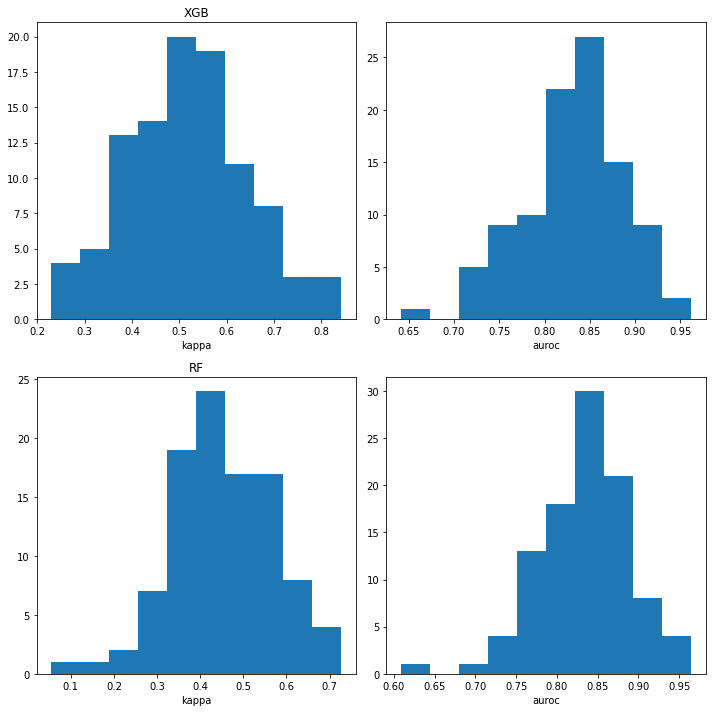

In [99]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist([x['cohen_kappa_score'] for x in ppb_xgb_accum]);
plt.xlabel('kappa')
plt.title('XGB')
plt.subplot(2,2,2)
plt.hist([x['roc_auc_score'] for x in ppb_xgb_accum]);
plt.xlabel('auroc')

plt.subplot(2,2,3)
plt.hist([x['cohen_kappa_score'] for x in ppb_rf_accum]);
plt.xlabel('kappa')
plt.title('RF')
plt.subplot(2,2,4)
plt.hist([x['roc_auc_score'] for x in ppb_rf_accum]);
plt.xlabel('auroc')

plt.tight_layout()


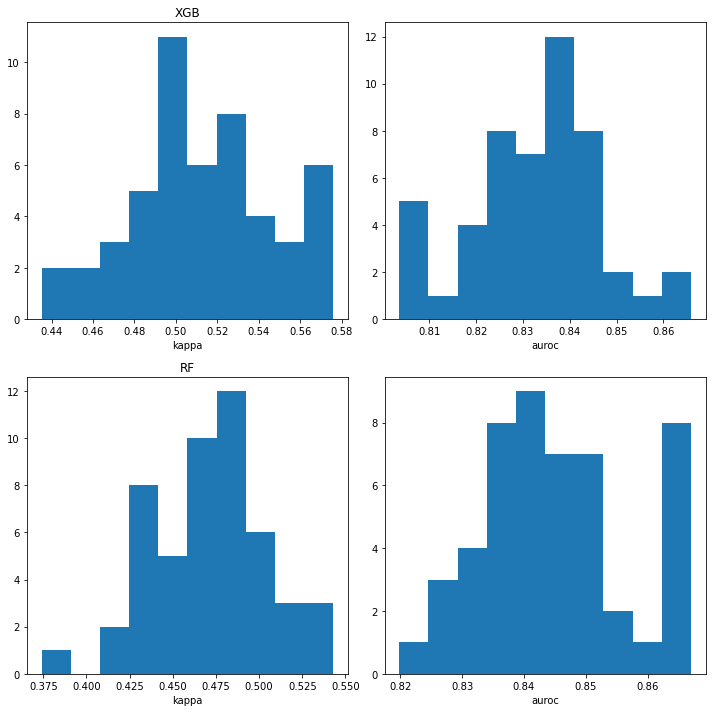

In [105]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist([np.mean(x['cohen_kappa_score']) for x in ppb_xgb_xc_accum]);
plt.xlabel('kappa')
plt.title('XGB')
plt.subplot(2,2,2)
plt.hist([np.mean(x['roc_auc_score']) for x in ppb_xgb_xc_accum]);
plt.xlabel('auroc')

plt.subplot(2,2,3)
plt.hist([np.mean(x['cohen_kappa_score']) for x in ppb_rf_xc_accum]);
plt.xlabel('kappa')
plt.title('RF')
plt.subplot(2,2,4)
plt.hist([np.mean(x['roc_auc_score']) for x in ppb_rf_xc_accum]);
plt.xlabel('auroc')

plt.tight_layout()


# Alternate ways of looking at the results

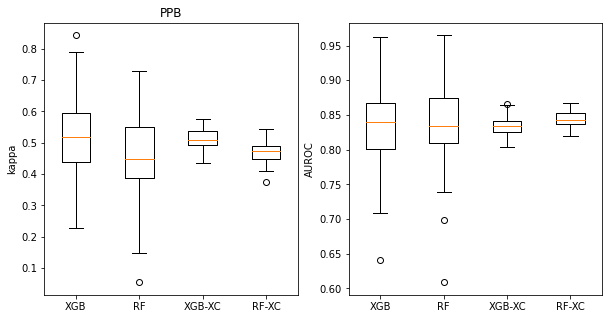

In [118]:
title = 'PPB'
t_rf = ppb_rf_accum
t_xgb = ppb_xgb_accum
t_rf_xc = ppb_rf_xc_accum
t_xgb_xc = ppb_xgb_xc_accum

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(([x['cohen_kappa_score'] for x in t_xgb],
             [x['cohen_kappa_score'] for x in t_rf],
             [np.mean(x['cohen_kappa_score']) for x in t_xgb_xc],
             [np.mean(x['cohen_kappa_score']) for x in t_rf_xc]
            ),labels=('XGB','RF','XGB-XC','RF-XC'));
plt.ylabel('kappa');
plt.title(title)

plt.subplot(1,2,2)
plt.boxplot(([x['roc_auc_score'] for x in t_xgb],
             [x['roc_auc_score'] for x in t_rf],
             [np.mean(x['roc_auc_score']) for x in t_xgb_xc],
             [np.mean(x['roc_auc_score']) for x in t_rf_xc]
            ),labels=('XGB','RF','XGB-XC','RF-XC'));
plt.ylabel('AUROC');


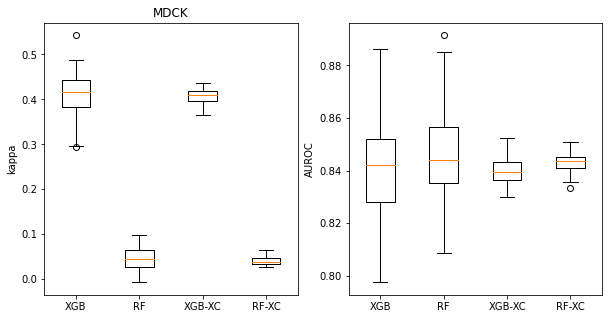

In [119]:
title = 'MDCK'
t_rf = mdck_rf_accum
t_xgb = mdck_xgb_accum
t_rf_xc = mdck_rf_xc_accum
t_xgb_xc = mdck_xgb_xc_accum

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(([x['cohen_kappa_score'] for x in t_xgb],
             [x['cohen_kappa_score'] for x in t_rf],
             [np.mean(x['cohen_kappa_score']) for x in t_xgb_xc],
             [np.mean(x['cohen_kappa_score']) for x in t_rf_xc]
            ),labels=('XGB','RF','XGB-XC','RF-XC'));
plt.ylabel('kappa');
plt.title(title)

plt.subplot(1,2,2)
plt.boxplot(([x['roc_auc_score'] for x in t_xgb],
             [x['roc_auc_score'] for x in t_rf],
             [np.mean(x['roc_auc_score']) for x in t_xgb_xc],
             [np.mean(x['roc_auc_score']) for x in t_rf_xc]
            ),labels=('XGB','RF','XGB-XC','RF-XC'));
plt.ylabel('AUROC');


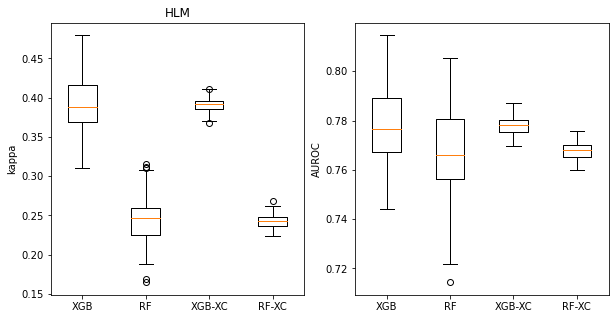

In [120]:
title = 'HLM'
t_rf = rf_accum
t_xgb = xgb_accum
t_rf_xc = rf_xc_accum
t_xgb_xc = xgb_xc_accum

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(([x['cohen_kappa_score'] for x in t_xgb],
             [x['cohen_kappa_score'] for x in t_rf],
             [np.mean(x['cohen_kappa_score']) for x in t_xgb_xc],
             [np.mean(x['cohen_kappa_score']) for x in t_rf_xc]
            ),labels=('XGB','RF','XGB-XC','RF-XC'));
plt.ylabel('kappa');
plt.title(title)

plt.subplot(1,2,2)
plt.boxplot(([x['roc_auc_score'] for x in t_xgb],
             [x['roc_auc_score'] for x in t_rf],
             [np.mean(x['roc_auc_score']) for x in t_xgb_xc],
             [np.mean(x['roc_auc_score']) for x in t_rf_xc]
            ),labels=('XGB','RF','XGB-XC','RF-XC'));
plt.ylabel('AUROC');


How often do we reach different conclusions?

kappa fraction>0: 0.86
AUC fraction>0: 0.16


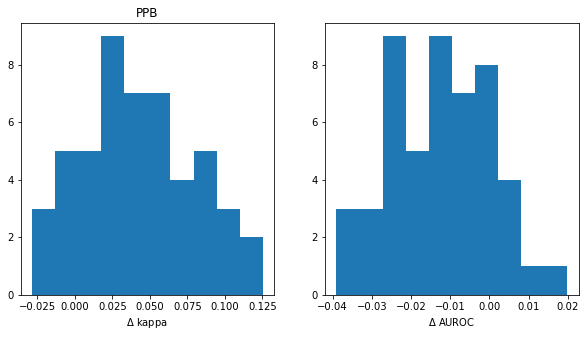

In [137]:
title = 'PPB'
t_rf = ppb_rf_accum
t_xgb = ppb_xgb_accum
t_rf_xc = ppb_rf_xc_accum
t_xgb_xc = ppb_xgb_xc_accum

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
diffs = [np.mean(x['cohen_kappa_score'])-np.mean(y['cohen_kappa_score']) for x,y in zip(t_xgb_xc,t_rf_xc)]
print(f'kappa fraction>0: {sum(np.array(diffs)>0)/len(diffs):.2f}')
plt.hist(diffs);
plt.title(title)
plt.xlabel('$\Delta$ kappa')
plt.subplot(1,2,2)
diffs = [np.mean(x['roc_auc_score'])-np.mean(y['roc_auc_score']) for x,y in zip(t_xgb_xc,t_rf_xc)]
print(f'AUC fraction>0: {sum(np.array(diffs)>0)/len(diffs):.2f}')

plt.hist(diffs);
plt.xlabel('$\Delta$ AUROC');


kappa fraction>0: 1.00
AUC fraction>0: 0.16


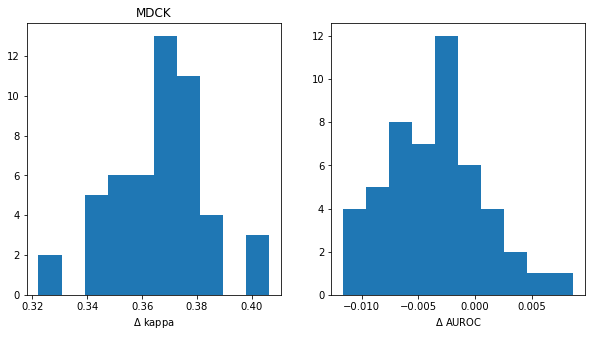

In [139]:
title = 'MDCK'
t_rf = mdck_rf_accum
t_xgb = mdck_xgb_accum
t_rf_xc = mdck_rf_xc_accum
t_xgb_xc = mdck_xgb_xc_accum

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
diffs = [np.mean(x['cohen_kappa_score'])-np.mean(y['cohen_kappa_score']) for x,y in zip(t_xgb_xc,t_rf_xc)]
print(f'kappa fraction>0: {sum(np.array(diffs)>0)/len(diffs):.2f}')
plt.hist(diffs);
plt.title(title)
plt.xlabel('$\Delta$ kappa')

plt.subplot(1,2,2)
diffs = [np.mean(x['roc_auc_score'])-np.mean(y['roc_auc_score']) for x,y in zip(t_xgb_xc,t_rf_xc)]
print(f'AUC fraction>0: {sum(np.array(diffs)>0)/len(diffs):.2f}')

plt.hist(diffs);
plt.xlabel('$\Delta$ AUROC');


kappa fraction>0: 1.00
AUC fraction>0: 1.00


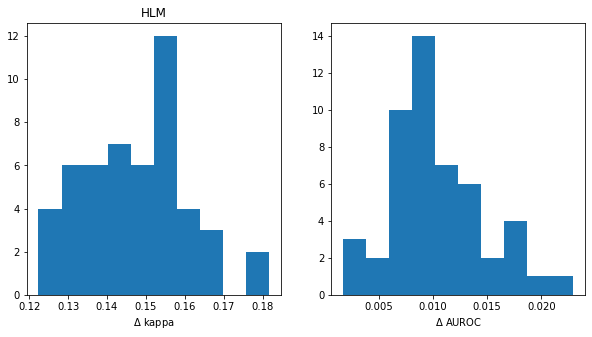

In [138]:
title = 'HLM'
t_rf = rf_accum
t_xgb = xgb_accum
t_rf_xc = rf_xc_accum
t_xgb_xc = xgb_xc_accum

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
diffs = [np.mean(x['cohen_kappa_score'])-np.mean(y['cohen_kappa_score']) for x,y in zip(t_xgb_xc,t_rf_xc)]
print(f'kappa fraction>0: {sum(np.array(diffs)>0)/len(diffs):.2f}')
plt.hist(diffs);
plt.title(title)
plt.xlabel('$\Delta$ kappa')

plt.subplot(1,2,2)
diffs = [np.mean(x['roc_auc_score'])-np.mean(y['roc_auc_score']) for x,y in zip(t_xgb_xc,t_rf_xc)]
print(f'AUC fraction>0: {sum(np.array(diffs)>0)/len(diffs):.2f}')

plt.hist(diffs);
plt.xlabel('$\Delta$ AUROC');
